# World Models

### 1. V-Model

### 2. M-Model

### 3. C-Model



In [4]:
import gym
from gym.spaces import Box
import numpy as np

try:
    import cv2
except ImportError:
    cv2 = None

In [5]:
# bring observation in desired shape and scale observation between 0 and 1
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
class ObservationWrapper(gym.Wrapper):
    def __init__(self, env, image_size=(64,64,3), scale_obs=True):
        super().__init__(env)
        self.shape = image_size
        self.screen_size = image_size[0]
        self.scale_obs = scale_obs
        _low, _high, _obs_dtype = (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        self.observation_space = Box(low=_low, high=_high, shape=image_size, dtype=_obs_dtype)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self._get_obs(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self._get_obs(obs)
        
    
    def _get_obs(self, obs):

        obs = cv2.resize(obs, (self.screen_size, self.screen_size))#, interpolation=cv2.INTER_AREA)

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        return obs
    
class PytorchWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs, reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs
        
        

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal

import matplotlib.pyplot as plt

# V-Model

In [79]:
class VAE():
    def __init__(self, state_size, latent_size_N=32, device="cpu"):
              
        self.encoder = Encoder(state_size, latent_size_N).to(device)
        self.decoder = Decoder(state_size, latent_size_N).to(device)
        self.device = device
        
        self.params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = optim.Adam(params=self.params, lr=0.001)
        #self.optimizer_decoder = optim.Adam(params=self.decoder.parameters(), lr=0.0001)
        
    def forward(self, image: torch.Tensor)-> torch.Tensor:
        
        assert image.shape == (image.shape[0] ,3, 64, 64), "Input Image as wrong shape!"
        mu, sig = self.encoder(image)
        encoded = self.sample(mu, sig)
        
        decoded = self.decoder(encoded)
        return decoded, (mu, sig)
    
    def encode_state(self, image: torch.Tensor)-> torch.Tensor:
        assert image.shape == (image.shape[0], 3, 64, 64), "Input Image as wrong shape!"
        encoded = self.encoder(image)
        return encoded
    
    def sample(self, mu, logsig):
            
        #dist = Normal(mu, sig) 
        #latent_vector_z = dist.sample()
        
        # in the paper they had different sample methods this one and mu + sig *N(0,1)
        #latent_vector_z = mu + sig * torch.normal(torch.zeros(1), torch.ones(1)).to(device)
        
        
        sigma = logsig.exp()
        eps = torch.randn_like(sigma)     
        return eps.mul(sigma).add_(mu)
        
    def train(self, dataloader:DataLoader)-> torch.Tensor:
        losses = {"loss1": [], "loss2": []}
        for idx, sample in enumerate(dataloader):
            
            image_batch = sample[0].to(device)
            reconstructed, (mu, sig) = self.forward(image_batch)
            
            loss_1 = kl_loss(mu, sig)
            loss_2 = l2_dist_loss(reconstructed, image_batch)
            
            self.optimizer.zero_grad()
            loss = (loss_1 + loss_2).mean()
            
            loss.backward()
            #clip_grad_norm_(self.params, 10.)
            self.optimizer.step()
            losses["loss1"].append(loss_1.detach().cpu().numpy())
            losses["loss2"].append(loss_2.detach().cpu().numpy())
        return np.mean(losses["loss1"]),np.mean(losses["loss2"]) 
            
            

def kl_loss(mu: torch.Tensor, sig:torch.Tensor)-> torch.Tensor:
    #loss = - 0.5 * (1 + torch.log(sig).pow(2) - sig.pow(2) - mu.pow(2)).sum()
    loss = -0.5 * torch.sum(1 + 2 * sig - mu.pow(2) - (2 * sig).exp())
    return loss

def l2_dist_loss(prediction:torch.Tensor, target:torch.Tensor)-> torch.Tensor:
    #return - torch.dist(target,prediction, p=2)
    return F.mse_loss(prediction, target, size_average=False)
    #return F.binary_cross_entropy(prediction, target, size_average=False)
        
class Encoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.output_mu = nn.Linear(1024, latent_size_N)
        self.output_sig = nn.Linear(1024, latent_size_N)
        #self.softplus = nn.Softplus() #use different activation?
        
    
    def forward(self, img):
        
        x = torch.relu(self.conv1(img))
        #print(x.shape)
        x = torch.relu(self.conv2(x))
        #print(x.shape)
        x = torch.relu(self.conv3(x))
        #print(x.shape)
        x = torch.relu(self.conv4(x))
        #print(x.shape)
        
        mu = self.output_mu(x.flatten(1)) #torch.tanh()
        log_sig = self.output_sig(x.flatten(1))#self.softplus()
        #sig = torch.sqrt(var)
                    
        return (mu, log_sig)

        
class Decoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Decoder, self).__init__()
        
        self.in_linear = nn.Linear(32, 1024)
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2)
        
    def forward(self, latent_vector):
        
        x = torch.relu(self.in_linear(latent_vector)).unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.deconv1(x))
        #print(x.shape)
        x = torch.relu(self.deconv2(x))
        #print(x.shape)
        x = torch.relu(self.deconv3(x))
        #print(x.shape)
        x = torch.sigmoid(self.deconv4(x))
        #print(x.shape)
        return x

# Create Samples with random policy


In [8]:
Episodes = 10
env = gym.make("CarRacing-v0")
env = MaxAndSkipEnv(env)
env = ObservationWrapper(env, image_size=(64,64,3), scale_obs=True)
env = PytorchWrapper(env)
states = []
for ep in range(Episodes):
    done=False
    state = env.reset()
    step_count = 0 ## First ~50 steps is zooming to start position. not needed for training
    while True:
        state, reward, done, _ = env.step(env.action_space.sample())
        step_count += 1
        if step_count > 50:
            states.append(state)
        
        if done:
            print("Ep: {} | Sample size: {}".format(ep, len(states)))
            break
        

/home/sebastian/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1039..1303 -> 264-tiles track
Ep: 0 | Sample size: 200
Track generation: 1147..1447 -> 300-tiles track
Ep: 1 | Sample size: 400
Track generation: 1267..1588 -> 321-tiles track
Ep: 2 | Sample size: 600
Track generation: 1273..1595 -> 322-tiles track
Ep: 3 | Sample size: 800
Track generation: 1104..1384 -> 280-tiles track
Ep: 4 | Sample size: 1000
Track generation: 1172..1476 -> 304-tiles track
Ep: 5 | Sample size: 1200
Track generation: 1074..1347 -> 273-tiles track
Ep: 6 | Sample size: 1400
Track generation: 1292..1619 -> 327-tiles track
Ep: 7 | Sample size: 1600
Track generation: 1253..1571 -> 318-tiles track
Ep: 8 | Sample size: 1800
Track generation: 1222..1532 -> 310-tiles track
Ep: 9 | Sample size: 2000


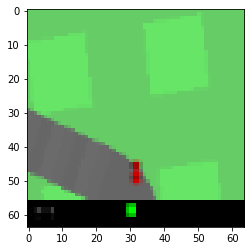

In [10]:
plt.imshow(states[175].squeeze().reshape(64,64,3))

# Create Dataset 

In [70]:
# Create Dataset of states
set = torch.cat(states, dim=0)
dataset = TensorDataset(set)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
V_model = VAE(state_size=state.shape, device=device)
print("Using: {}".format(device))

Using: cuda:0


In [81]:
Epochs = 25
losses = {"loss1": [], "loss2": [], "loss": []}
for i in range(Epochs):
    loss1, loss2 = V_model.train(dataloader)
    print("Epoch: {} | kl_loss: {:.2f} | l2_loss: {:.2f}".format(i, loss1, loss2))
    losses["loss1"].append(loss1)    
    losses["loss2"].append(loss2)    
    losses["loss"].append(loss1+loss2)

Epoch: 0 | kl_loss: 252.46 | l2_loss: 166874.00
Epoch: 1 | kl_loss: 189.39 | l2_loss: 94056.22
Epoch: 2 | kl_loss: 5.75 | l2_loss: 57636.94
Epoch: 3 | kl_loss: 3.04 | l2_loss: 43683.79
Epoch: 4 | kl_loss: 3.24 | l2_loss: 35950.03
Epoch: 5 | kl_loss: 3.32 | l2_loss: 31366.36
Epoch: 6 | kl_loss: 3.43 | l2_loss: 28664.41
Epoch: 7 | kl_loss: 3.40 | l2_loss: 27102.43
Epoch: 8 | kl_loss: 3.31 | l2_loss: 26123.50
Epoch: 9 | kl_loss: 3.74 | l2_loss: 25471.71
Epoch: 10 | kl_loss: 11.59 | l2_loss: 24852.25
Epoch: 11 | kl_loss: 26.69 | l2_loss: 24415.58
Epoch: 12 | kl_loss: 23.02 | l2_loss: 24055.66
Epoch: 13 | kl_loss: 25.70 | l2_loss: 23768.95
Epoch: 14 | kl_loss: 27.53 | l2_loss: 23529.75
Epoch: 15 | kl_loss: 30.38 | l2_loss: 23342.84
Epoch: 16 | kl_loss: 24.43 | l2_loss: 23192.20
Epoch: 17 | kl_loss: 32.24 | l2_loss: 23073.93
Epoch: 18 | kl_loss: 30.53 | l2_loss: 22977.61
Epoch: 19 | kl_loss: 39.39 | l2_loss: 22920.45
Epoch: 20 | kl_loss: 34.69 | l2_loss: 22811.34
Epoch: 21 | kl_loss: 36.79 |

<function matplotlib.pyplot.show(close=None, block=None)>

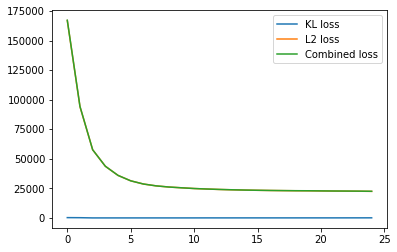

In [82]:
import matplotlib.pyplot as plt
plt.plot(losses["loss1"], label="KL loss")
plt.plot(losses["loss2"], label="L2 loss")
plt.plot(losses["loss"], label="Combined loss")
plt.legend()

plt.show

# Observe training results

In [83]:
len(states)

2000

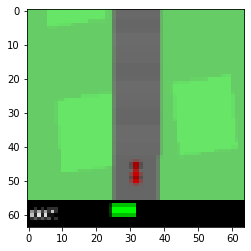

In [91]:
# select example image
plt.imshow(states[2].squeeze().reshape(64,64,3))

In [92]:
# view reconstructed image

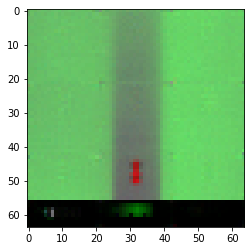

In [93]:
reconstr, _ = V_model.forward(states[2].to(device))
plt.imshow(reconstr.detach().cpu().numpy().reshape(64,64,3))

# M-Model

In [80]:
class MModel(nn.Module):
    def __init__(self, action_size, latent_size=32, hidden_size=256, batch_size=64, n_gaussians=5, rnn_type="LSTM"):
        super(MModel, self).__init__()
        
        self.input_shape = action_size+latent_size
        self.action_size = action_size
        self.latent_size = latent_size
        self.n_gaussians = n_gaussians
        self.batch_size = batch_size
        
        if rnn_type == "LSTM":
            self.rnn_layer = nn.LSTM(self.input_shape, hidden_size, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn_layer = nn.GRU(self.input_shape, hidden_size, batch_first=True)
            
        self.pi_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        self.mu_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        self.sig_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        
        
    def forward(self, latent_vector: torch.Tensor, action:torch.Tensor, hidden_state=None)-> torch.Tensor:
        """ Simple forward pass with the RNN """
        
        assert latent_vector.shape == (latent_vector.shape[0], self.latent_size), "Latent vector has the wrong shape!"
        assert action.shape == (action.shape[0], self.action_size), "Action batch has the wrong shape!"
        
        input_tensor = torch.cat((latent_vector, action),dim=1).unsqueeze(1)
        assert input_tensor.shape == (action.shape[0], 1, self.input_shape), "input_tensor has wrong shape!"
        
        output, hidden_state = self.rnn_layer(input_tensor, hidden_state)
        
        (pi, mu, sigma) = self.get_gauss_coeffs(output)
        return (pi, mu, sigma), hidden_state
    
    
    def get_gauss_coeffs(self, y:torch.Tensor):
        
        rollout_length = y.size(1)
        
        pi = self.pi_layer(y)
        mu = self.mu_layer(y)
        sigma = self.sig_layer(y)
        
        pi = pi.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        mu = mu.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        sigma = sigma.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        
        pi = F.softmax(pi, 2)
        sigma = torch.exp(sigma)
        return pi, mu, sigma
    
    def predict_next_z(self,latent_vector: torch.Tensor, action:torch.Tensor, tau: float, hidden_state=None)-> torch.Tensor:
        """ Predicts the next Latent Vector Z """
        values, hidden_state = self.forward(latent_vector, action, hidden_state)
        mu, sigma = values[1], values[2]
        
        dist = Normal(mu, sigma*tau)
        z_ = dist.sample().mean(2)
        print(z_.shape)
        
        prediction = [torch.normal(mu, sigma)[:, :, i, :] for i in range(self.n_gaussians)]
        return prediction, hidden_state
        
# M-Model loss calculation
def mdn_loss_fn(y, pi, mu, sigma):
    m = Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()


def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(2)
    return mdn_loss_fn(y, pi, mu, sigma)

In [81]:
m_model = MModel(action_size=4)

In [82]:
action = torch.ones((1,4))
z, hidden = m_model(out, action)

In [83]:
z_, h = m_model.predict_next_z(out, action, None)

torch.Size([1, 1, 32])


In [71]:
z_[4].shape

torch.Size([1, 1, 32])